In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd
import numpy as np
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
np.random.seed(seed=0)
random.seed(0)

In [4]:
abnormal = np.load('abnormal.npy', allow_pickle=True)
normal = np.load('normal.npy', allow_pickle=True)
sim_dataset = np.load('sim_dataset.npy', allow_pickle=True)
#X_train = np.load("X_train.npy", allow_pickle=True)
# X_test = np.load("X_test.npy", allow_pickle=True)
# y_train = np.load("y_train.npy", allow_pickle=True)
# y_test = np.load("y_test.npy", allow_pickle=True)
# labels = np.load("unique_labels.npy", allow_pickle=True)

In [5]:
print(abnormal.shape)
print(normal.shape)
print(sim_dataset.shape)

(2664, 3600)
(7402, 3600)
(5100, 3600)


In [6]:
np.ones([abnormal.shape[0], 1]).shape

(2664, 1)

In [10]:
### packages
import os
from copy import deepcopy
import torch
import numpy as np

### sys relative to root dir
import sys
from os.path import dirname, realpath
#sys.path.append(dirname(dirname(realpath(__file__))))

### absolute imports wrt root
from codes.factory import FactoryDefinition, Factory_SimGAN

PROBLEM_TYPE = "ecg"
if PROBLEM_TYPE == "":
    from problems.problem_simgan import Problem
elif PROBLEM_TYPE == "ecg":
    from problems.problem_simgan_ecg import Problem
elif PROBLEM_TYPE == "transform":
    from problems.problem_simgan_transform import Problem
else:
    print("don't have that one yet")
    exit()



def build_individual(individual_pkl):
    '''
    a lot of this is just going to mimic factory.Factory_SimGAN.build_individual_from_seed
    but use the trained weights instead!
    '''
    problem = Problem()
    indiv_def = problem.indiv_def
    factory = Factory_SimGAN()


    # try to grab id from name
    try:
        indiv_id = os.path.basename(individual_pkl).split("_")[-1].split(".")[0]
    except Exception as err:
        print("Couldn't get id for some reason:\n%s" % err)
        indiv_id = "poopie_face"

    individual = factory.build_individual_from_seed(indiv_def,
                                                    individual_pkl,
                                                    problem.maximize_objectives,
                                                    indiv_id=indiv_id)

    refiner, discriminator = deepcopy(individual.output)
    del individual

    return refiner, discriminator


refinerseed, _ = build_individual('gen_0009_indiv_2d311ddb156f0.pkl')
refinerevo, _ = build_individual('gen_0000_indiv_seededIndiv0-1.pkl')

(32, 1, 3600)
(400, 1, 3600)
_______________________________
(32, 1, 3600)
(400, 1, 3600)
_______________________________
(32, 1, 3600)
(400, 1, 3600)
_______________________________
(32, 1, 3600)
(400, 1, 3600)
_______________________________


In [11]:
class WrapperDataset(Dataset):
    ''' A wrapper class for the torch.Dataset
    '''
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float().unsqueeze(1)
        self.target = torch.from_numpy(target).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


In [58]:
sim_loader = DataLoader(sim_dataset, batch_size=1, shuffle=False)
seed_ref = []
for i, data in enumerate(sim_loader):
    # get the inputs; data is a list of [inputs, labels]
    outputs = refinerseed(data.unsqueeze(1).float())
    seed_ref.append(outputs.detach().numpy().squeeze())
seed_ref = np.array(seed_ref)


sim_loader = DataLoader(sim_dataset, batch_size=1, shuffle=False)
evo_ref = []
for i, data in enumerate(sim_loader):
    # get the inputs; data is a list of [inputs, labels]
    outputs = refinerevo(data.unsqueeze(1).float())
    evo_ref.append(outputs.detach().numpy().squeeze())
evo_ref = np.array(evo_ref)



In [59]:
#make normal dataset
unsim_x = np.concatenate([abnormal, normal])
unsim_y = np.concatenate([np.ones([abnormal.shape[0], 1]), np.zeros([normal.shape[0], 1])])
print(unsim_x.shape)
print(unsim_y.shape)



#make simulated dataset
sim_x = np.concatenate([unsim_x, sim_dataset])
sim_y = np.concatenate([unsim_y, np.zeros([sim_dataset.shape[0], 1])])
print(sim_x.shape)
print(sim_y.shape)


#make seedref dataset
seedref_x = np.concatenate([unsim_x, seed_ref])
seedref_y = np.concatenate([unsim_y, np.ones([sim_dataset.shape[0], 1])])
print(seedref_x.shape)
print(seedref_y.shape)

#make evoref dataset
evoref_x = np.concatenate([unsim_x, evo_ref])
evoref_y = np.concatenate([unsim_y, np.ones([sim_dataset.shape[0], 1])])
print(evoref_x.shape)
print(evoref_y.shape)


unsim_x_train, unsim_x_test, unsim_y_train, unsim_y_test = train_test_split(unsim_x, unsim_y, test_size=0.25, random_state=42)
sim_x_train, sim_x_test, sim_y_train, sim_y_test = train_test_split(sim_x, sim_y, test_size=0.25, random_state=42)
seedref_x_train, seedref_x_test, seedref_y_train, seedref_y_test = train_test_split(seedref_x, seedref_y, test_size=0.25, random_state=42)
evoref_x_train, evoref_x_test, evoref_y_train, evoref_y_test = train_test_split(evoref_x, evoref_y, test_size=0.25, random_state=42)



(10066, 3600)
(10066, 1)
(15166, 3600)
(15166, 1)
(15166, 3600)
(15166, 1)
(15166, 3600)
(15166, 1)


In [82]:
def train_model(model, trainx, trainy):
    model.fit(trainx, trainy)

def test_model(model, testx, testy, lab):
    y_pred = model.predict(testx)
    print(classification_report(testy, y_pred))
    print(f1_score(testy, y_pred))
    cf_matrix = confusion_matrix(testy, y_pred, normalize='all')
    plt.title(f"Confusion Matrix {lab}") # title with fontsize 20
    plt.xlabel('Predicted') # x-axis label with fontsize 15
    plt.ylabel('True') # y-axis label with fontsize 15
    sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g', yticklabels=['Normal', 'Abnormal'], xticklabels=['Normal', 'Abnormal'])

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79      1835
         1.0       0.43      0.43      0.43       682

    accuracy                           0.69      2517
   macro avg       0.61      0.61      0.61      2517
weighted avg       0.69      0.69      0.69      2517

0.4343360234776229


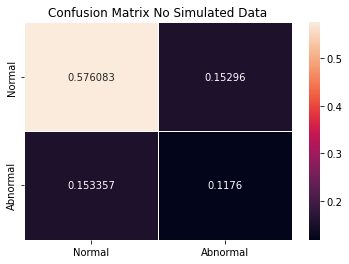

In [83]:
clf_unsim = DecisionTreeClassifier(random_state=42)
train_model(clf_unsim, unsim_x_train, unsim_y_train)
test_model(clf_unsim, unsim_x_test, unsim_y_test, 'No Simulated Data')

              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88      3115
         1.0       0.46      0.49      0.48       677

    accuracy                           0.81      3792
   macro avg       0.68      0.68      0.68      3792
weighted avg       0.81      0.81      0.81      3792

0.47748391708363114


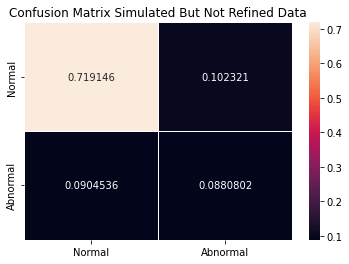

In [84]:
clf_sim = DecisionTreeClassifier(random_state=42)
train_model(clf_sim, sim_x_train, sim_y_train)
test_model(clf_sim, sim_x_test, sim_y_test, 'Simulated But Not Refined Data')

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80      1867
         1.0       0.81      0.80      0.80      1925

    accuracy                           0.80      3792
   macro avg       0.80      0.80      0.80      3792
weighted avg       0.80      0.80      0.80      3792

0.8043761396196927


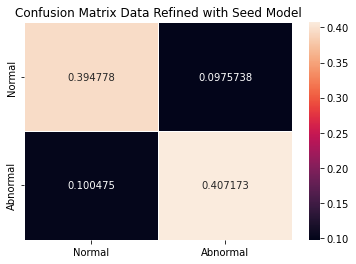

In [85]:
clf_seed = DecisionTreeClassifier(random_state=42)
train_model(clf_seed, seedref_x_train, seedref_y_train)
test_model(clf_seed, seedref_x_test, seedref_y_test, 'Data Refined with Seed Model')

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      1867
         1.0       0.81      0.82      0.82      1925

    accuracy                           0.81      3792
   macro avg       0.81      0.81      0.81      3792
weighted avg       0.81      0.81      0.81      3792

0.8158232725404572


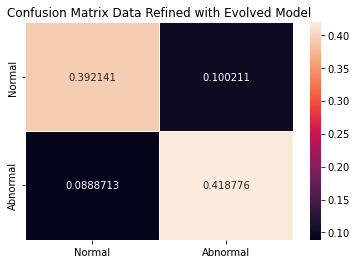

In [86]:
clf_evo = DecisionTreeClassifier(random_state=42)
train_model(clf_evo, evoref_x_train, evoref_y_train)
test_model(clf_evo, evoref_x_test, evoref_y_test, 'Data Refined with Evolved Model')

In [111]:
from PIL import Image
def generate_ecg_img(syn_batch, ref_batch, real_batch, png_path, ref_preds=None, real_preds=None):
    '''
    Generates matplotlib plots of 3 syn, ref, and real examples from the step.
    '''
    # # syn_batch_type: Tensor, ref_batch_type: Tensor, real_batch_type: Tensor
    #syn_batch = syn_batch[:5]
    #ref_batch = ref_batch[:5]
    #real_batch = real_batch[:5]

    fig = plt.figure(figsize=(16, 9))

    ax = fig.add_subplot(1, 3, 1)
    for i in range(1):
        print(syn_batch[i].numpy())
        ax.plot(syn_batch[i].numpy())
    ax.set_ylim([-1, 1])
    ax.set_title("Random Simulated Signal")
    ax = fig.add_subplot(1, 3, 2)
    for i in range(1):
        if ref_preds is not None:
            ref_probs = torch.sigmoid(ref_preds[i]).item()
            label = str([1 - ref_probs, ref_probs])
        else:
            label=None
        ax.plot(ref_batch[i].numpy(), label=label)
    ax.set_ylim([-1, 1])
    ax.set_title("Refined Signal")
    plt.legend()
    ax = fig.add_subplot(1, 3, 3)
    for i in range(1):
        if real_preds is not None:
            real_probs = torch.sigmoid(real_preds[i]).item()
            label = str([1 - real_probs, real_probs])
        else:
            label=None
        ax.plot(real_batch[i].numpy(), label=label, color='orange')
    plt.legend()
    ax.set_ylim([-1, 1])
    ax.set_title("Random Real Signal")
    plt.tight_layout()

    fig.canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)

    img = Image.fromarray(img)

    img.save(png_path, 'eps')

    plt.close()
generate_ecg_img(torch.Tensor(sim_dataset[0:2]), torch.Tensor(seed_ref[0:2]), torch.Tensor(abnormal[0:2]), 'seed')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[1.0818942  1.0607066  1.005369   ... 0.13197848 0.12236015 0.11307615]


/home/anishthite/miniconda3/envs/simgan-cgp/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [103]:
torch.Tensor(abnormal[0:1])

tensor([[-0.2000, -0.2000, -0.2000,  ..., -0.3700, -0.3600, -0.3600]])

In [94]:
!pip install image

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 7.9 MB 6.0 MB/s            
  Using cached sqlparse-0.4.2-py3-none-any.whl (42 kB)
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19494 sha256=bcf20ef8ecf414352124db7588613f1f30e07ffb19079b95718950a56895cae7
  Stored in directory: /home/anishthite/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built image
